# IST664 Final Project: Kaggle Movie Reviews
### Author: Abdullah Naimzadeh
#### Due: May 12th, 2021

I used to go to the movies with my sister at least twice a month prior to the pandemic as a bonding activity. Every movie she would want to see would be met with, "well let me check Rotten Tomatoes and Metacritic" to see what the general feeling was for the movie. I hated wasting money on a bad flick. I can assume I am not alone. Both websites have meters that measures the _good tomatoes from the bad_ by the critics. But what about the user reviews? How would one gauge their sentiment. That is something I have always been curious about, especially if their is not explicit button that says this movie was great. But what would that mean; A great disappointment, or a great ride? This is something ambigous and hard to decipher by a computer. Luckily though NLP has explored this field of using ML algorithms to try and classify reviews, or in my case tomatoes.

In the following invstigation, we will try to use the techniques used in class to process a corpus and predict whether or not a review was positive or negative. 

## Import Relevant Libraries

First we import the necessary libraries that will help us carry out our work.

In [203]:
from nltk import *
import random
import re
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import FreqDist
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Understanding the Data Set

First, lets take a look at the files we were given.

In [124]:
os.listdir()

['train.tsv', 'sampleSubmission.csv', 'test.tsv']

In our directory, the original files are:
- python classification programs 
- a folder containing the actual data
- some additional features we can add to process the text

Now let's evaluate the corpus.

In [274]:
path = '/Users/princeabu/Desktop/GradSchool/Classes/IST664/FinalProj/FinalProjectData/kagglemoviereviews/'
os.chdir(path)
os.listdir()

['classifyKaggle.crossval.py',
 'sentiment_read_subjectivity.py',
 '.DS_Store',
 'SentimentLexicons',
 'Untitled.ipynb',
 'corpus',
 '__pycache__',
 'sentiment_read_LIWC_pos_neg_words.py',
 'classifyKaggle.py',
 '.ipynb_checkpoints',
 '_DS_Store']

In [275]:
text_path = '/Users/princeabu/Desktop/GradSchool/Classes/IST664/FinalProj/FinalProjectData/kagglemoviereviews/corpus'

In [276]:
train_list = pd.read_csv(text_path + '/train.tsv',sep = '\t')
test_list = pd.read_csv(text_path + '/test.tsv',sep = '\t')

In [170]:
print(test_list.info())
print(train_list.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB
None


We know that the training set contains 156,060 phrases. Looking at the number of phrases in the testing set, we see its almost half of the size of the training set. This is important to indicate becauese usually the ratio of training to testing is 3:1 or 5:1 depending on the size of our data set and how generalizable we want our models to be.

In [171]:
train_list.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


When we take a look at the first ten observations, we see each phase is assigned a unique phrase id. Some of the phrases can be from the same sentence, as indicated by the sentence id, and they are tagged with a human-assigned sentiment score ranging from 0-4, with 4 being the most positive, 2 being neutral and 0 being negative.

In [277]:
train_list.Phrase[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [278]:
train_list.Sentiment.value_counts(1)

2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentiment, dtype: float64

From the above output of valuecounts, we can see that our data set is imbalanced. About half of the sentiment scores are nuetral while the percentage of polarity, off-neutral, is significantly lower, especially the count of totally positive reviews. In the real world this would make sense since negative reviews will draw readers' attention. But in the case of creating a model that can accurately predict the sentiment of the review, a more balanced dataset would serve us better.

# Part 2: Text Classification

We will be using NaiveBayes as our main classification algorithm, and Support Vector Machines as another model to compare to. The python program provided utilizes function calls that will process the text, trains and tests the classifier with k-fold = 5 cross-validation, and finally outputs the results of the precision, recall and f1 score for each fold. Since the data is imbalanced, we will be looking mainly at the micro averages when comparing each new model we create and select the best one to account for the minority labels.

Since there are over 150,000 observations in our training set, we will select a subset as to reduce the training time. Just as a comparision, when we use all data points in our dataset, the results can be shown as below. This is the highest baseline score, but takes a significant amount of time run. 

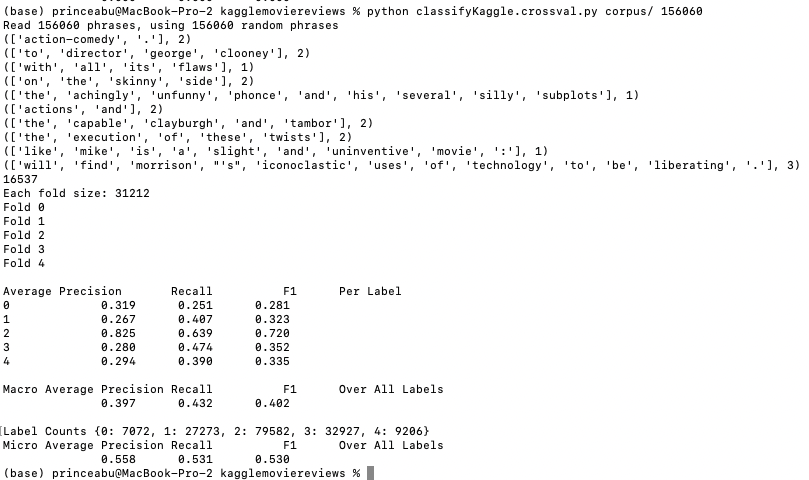

If we were to run the program with 1000 as our input, we get a reduction in our f1 by almost half, but it takes only about 10 seconds to run. We decide to run the model with 5000 random phrases to be selected so that each fold is given 1000 different inputs. This takes a little less than a minute to run, but the baseline scores are comparable to the scores when we use the whole training set. Below if the python file that we will be adding to and running.

In [200]:
## this code is commented off now, but can be used for sentiment lists
#import sentiment_read_subjectivity
# initialize the positive, neutral and negative word lists
#(positivelist, neutrallist, negativelist) 
#    = sentiment_read_subjectivity.read_three_types('SentimentLexicons/subjclueslen1-HLTEMNLP05.tff')

#import sentiment_read_LIWC_pos_neg_words
# initialize positve and negative word prefix lists from LIWC 
#   note there is another function isPresent to test if a word's prefix is in the list
#(poslist, neglist) = sentiment_read_LIWC_pos_neg_words.read_words()

## define a feature definition function here

# this function define features (keywords) of a document for a BOW/unigram baseline
# each feature is 'V_(keyword)' and is true or false depending
# on whether that keyword is in the document
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

## cross-validation ##
# this function takes the number of folds, the feature sets and the labels
# it iterates over the folds, using different sections for training and testing in turn
#   it prints the performance for each fold and the average performance at the end
def cross_validation_PRF(num_folds, featuresets, labels):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    # for the number of labels - start the totals lists with zeroes
    num_labels = len(labels)
    total_precision_list = [0] * num_labels
    total_recall_list = [0] * num_labels
    total_F1_list = [0] * num_labels

    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round to produce the gold and predicted labels
        goldlist = []
        predictedlist = []
        for (features, label) in test_this_round:
            goldlist.append(label)
            predictedlist.append(classifier.classify(features))

        # computes evaluation measures for this fold and
        #   returns list of measures for each label
        print('Fold', i)
        (precision_list, recall_list, F1_list) \
                  = eval_measures(goldlist, predictedlist, labels)
        # take off triple string to print precision, recall and F1 for each fold
        '''
        print('\tPrecision\tRecall\t\tF1')
        # print measures for each label
        for i, lab in enumerate(labels):
            print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
              "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
        '''
        # for each label add to the sums in the total lists
        for i in range(num_labels):
            # for each label, add the 3 measures to the 3 lists of totals
            total_precision_list[i] += precision_list[i]
            total_recall_list[i] += recall_list[i]
            total_F1_list[i] += F1_list[i]

    # find precision, recall and F measure averaged over all rounds for all labels
    # compute averages from the totals lists
    precision_list = [tot/num_folds for tot in total_precision_list]
    recall_list = [tot/num_folds for tot in total_recall_list]
    F1_list = [tot/num_folds for tot in total_F1_list]
    # the evaluation measures in a table with one row per label
    print('\nAverage Precision\tRecall\t\tF1 \tPer Label')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
    
    # print macro average over all labels - treats each label equally
    print('\nMacro Average Precision\tRecall\t\tF1 \tOver All Labels')
    print('\t', "{:10.3f}".format(sum(precision_list)/num_labels), \
          "{:10.3f}".format(sum(recall_list)/num_labels), \
          "{:10.3f}".format(sum(F1_list)/num_labels))

    # for micro averaging, weight the scores for each label by the number of items
    #    this is better for labels with imbalance
    # first intialize a dictionary for label counts and then count them
    label_counts = {}
    for lab in labels:
      label_counts[lab] = 0 
    # count the labels
    for (doc, lab) in featuresets:
      label_counts[lab] += 1
    # make weights compared to the number of documents in featuresets
    num_docs = len(featuresets)
    label_weights = [(label_counts[lab] / num_docs) for lab in labels]
    print('\nLabel Counts', label_counts)
    #print('Label weights', label_weights)
    # print macro average over all labels
    print('Micro Average Precision\tRecall\t\tF1 \tOver All Labels')
    precision = sum([a * b for a,b in zip(precision_list, label_weights)])
    recall = sum([a * b for a,b in zip(recall_list, label_weights)])
    F1 = sum([a * b for a,b in zip(F1_list, label_weights)])
    print( '\t', "{:10.3f}".format(precision), \
      "{:10.3f}".format(recall), "{:10.3f}".format(F1))
    

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output: returns lists of precision, recall and F1 for each label
#      (for computing averages across folds and labels)
def eval_measures(gold, predicted, labels):
    
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []

    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        # for small numbers, guard against dividing by zero in computing measures
        if (TP == 0) or (FP == 0) or (FN == 0):
          recall_list.append (0)
          precision_list.append (0)
          F1_list.append(0)
        else:
          recall = TP / (TP + FP)
          precision = TP / (TP + FN)
          recall_list.append(recall)
          precision_list.append(precision)
          F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    return (precision_list, recall_list, F1_list)

## function to read kaggle training file, train and test a classifier 
def processkaggle(dirPath,limitStr):
  # convert the limit argument from a string to an int
  limit = int(limitStr)
  
  os.chdir(dirPath)
  
  f = open('./train.tsv', 'r')
  # loop over lines in the file and use the first limit of them
  phrasedata = []
  for line in f:
    # ignore the first line starting with Phrase and read all lines
    if (not line.startswith('Phrase')):
      # remove final end of line character
      line = line.strip()
      # each line has 4 items separated by tabs
      # ignore the phrase and sentence ids, and keep the phrase and sentiment
      phrasedata.append(line.split('\t')[2:4])
  
  # pick a random sample of length limit because of phrase overlapping sequences
  random.Random(664).shuffle(phrasedata)
  phraselist = phrasedata[:limit]

  print('Read', len(phrasedata), 'phrases, using', len(phraselist), 'random phrases')
  
  # create list of phrase documents as (list of words, label)
  phrasedocs = []
  # add all the phrases

  # each phrase has a list of tokens and the sentiment label (from 0 to 4)
  ### bin to only 3 categories for better performance
  for phrase in phraselist:
    tokens = nltk.word_tokenize(phrase[0])
    phrasedocs.append((tokens, int(phrase[1])))

  # possibly filter tokens
  # lowercase - each phrase is a pair consisting of a token list and a label
  docs = []
  for phrase in phrasedocs:
    lowerphrase = ([w.lower() for w in phrase[0]], phrase[1])
    docs.append (lowerphrase)
  # print a few
  for phrase in docs[:10]:
    print (phrase)

  # continue as usual to get all words and create word features
  all_words_list = [word for (sent,cat) in docs for word in sent]
  all_words = nltk.FreqDist(all_words_list)
  print(len(all_words))

  # get the 1500 most frequently appearing keywords in the corpus
  word_items = all_words.most_common(1500)
  word_features = [word for (word,count) in word_items]

  # feature sets from a feature definition function
  featuresets = [(document_features(d, word_features), c) for (d, c) in docs]

  # train classifier and show performance in cross-validation
  # make a list of labels
  label_list = [c for (d,c) in docs]
  labels = list(set(label_list))    # gets only unique labels
  num_folds = 5
  cross_validation_PRF(num_folds, featuresets, labels)


"""
commandline interface takes a directory name with kaggle subdirectory for train.tsv
   and a limit to the number of kaggle phrases to use
It then processes the files and trains a kaggle movie review sentiment classifier.

"""

processkaggle(text_path, 5000)


Read 156060 phrases, using 5000 random phrases
(['its', 'hint', 'of', 'an', 'awkward', 'hitchcockian', 'theme', 'in', 'tact'], 2)
(['while', 'somewhat', 'less', 'than', 'it', 'might', 'have', 'been', ',', 'the', 'film', 'is', 'a', 'good', 'one'], 3)
(['an', 'asset', 'and'], 3)
(['throws', 'quirky', 'characters', ',', 'odd', 'situations', ',', 'and', 'off-kilter', 'dialogue', 'at', 'us', ',', 'all', 'as', 'if', 'to', 'say', ',', '``', 'look', 'at', 'this'], 2)
(['a', 'doctor', "'s", 'office', ',', 'emergency', 'room', ',', 'hospital', 'bed', 'or', 'insurance', 'company', 'office'], 3)
(['a', 'powerful', 'though', 'flawed', 'movie', ',', 'guaranteed', 'to', 'put', 'a', 'lump', 'in', 'your', 'throat', 'while', 'reaffirming', 'washington', 'as', 'possibly', 'the', 'best', 'actor', 'working', 'in', 'movies', 'today'], 3)
(['artfully', 'lighted', ',', 'earnest', 'inquiries'], 3)
(['with', 'these', 'people'], 2)
(['so', 'convincingly'], 3)
(['druggy', 'and', 'self-indulgent', ',', 'like', 'a'

### To reduce complexitity, we decide couple the _somewhat_ ratings with their respective marker. This will increase the count of overall positive and negative reviews in attempts to create a more balanced training and testing set, with three categories instead of five.

The code below was added to the processKaggle function, and obtain the following results.


    ## -----------Added to reduce complexity -------## 
    rating = int(phrase[1])
    if(rating < 2):
        phrasedocs.append((tokens,'positive'))
    elif(rating > 2):
        phrasedocs.append((tokens,'negative'))
    elif(rating == 2):
        phrasedocs.append((tokens,'neutral'))
        
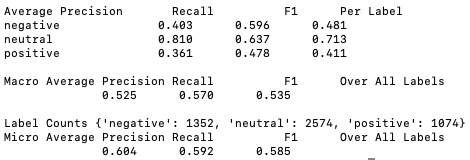

It would seem like our model improved overall! We see that the neutral reviews remain having the largest scores. But as mentioned before, there is an inbalance in the distribution of review sentiments so this would make sense why it scores higher. However, we see that by binning reviews, we are able to improve our model accross precision, recall and F1 score. This shall be established as our baseline results to compare subsequent models to.

Following the steps similar as we have done in lab, we can remove stopwords, negation words, use bigram/n-gram frequencies, etc to optimize our model during training. Let's first start with stopwords since that's the easiest. 

The code below was added to the processKaggle function, and obtain the following results.

nltkstopwords = nltk.corpus.stopwords.words('english') 

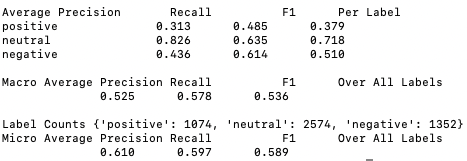

Removing stopwords improves our results, _on average_ and overall. We will choose to keep stopwords for now and later combine them with other filters to see how they fair. 

Since we have a large corpus of reviews, perhaps creating a bigram extracter will yield improved results. Bigrams allow us to couple words that appear more often together than individually. If those combinations of words are found to be biased towards one sentiment then that will allow our model to retain that bias for classification

The function below was added to the python file and the code below it was added to processKaggle, and obtain the following results.

$$__def bigram_document_features(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)    
    return features__$$

finder = BigramCollocationFinder.from_words(all_words_list)

bigram_measures = nltk.collocations.BigramAssocMeasures()

bigram_features = finder.nbest(bigram_measures.chi_sq, 500)

featuresets = [(bigram_document_features(d, word_features, bigram_features), c) for (d, c) in docs]

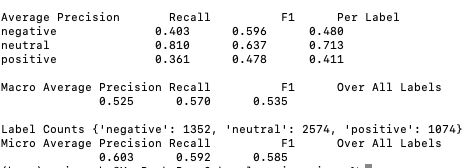

We see that implementing bigrams with the dependency of a chi-square measure did not improve our model _on average_. The F1 score of classifying positive reviews decreased whereas the F1 score of classifying negative reviews increased.  We will try bigrams once more but this time with a raw frequency measure and see if that bodes better. The results are shown below.

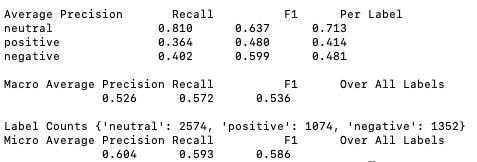

It looks like there is a very small increase in overall accuracy and generally across all sentiments as well when we used raw frequency in our bigram measure. Returning to unigrams, we will now see how tagging the parts of speech will affect classifying the documents. Parts of Speech could perhaps be beneficial because of the unique information they give about surrounding words. 

The function below was added to the python file and the code below it was added to processKaggle, and obtain the following results.

$$__def POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return featuresdef POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features __$$
    
featuresets = [(POS_features(d, word_features), c) for (d, c) in docs]   

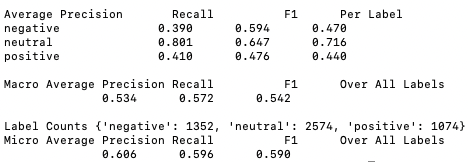


Including the POS tagged feature set improved across all counts! This is promising and we can take a note to incorporate this with other feature sets. Let us evaluate how removing negation words will affect our results. Negation words create negative meanings and handling them can be tricky, especially in lengthy reviews. Here we simplfy the issue by getting rid of these _quasi negative_ words. 

The function below was added to the python file and the code below it was added to processKaggle, and obtain the following results.


negationwords = ['no', 'not', 'never', 'none', 'nowhere', 'nothing', 'noone', 'rather', 'hardly', 'scarcely', 'rarely', 'seldom', 'neither', 'nor']

$$__def NOT_features(document, word_features, negationwords):
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = False
        features['V_NOT{}'.format(word)] = False
    # go through document words in order
    for i in range(0, len(document)):
        word = document[i]
        if ((i + 1) < len(document)) and ((word in negationwords) or (word.endswith("n't"))):
            i += 1
            features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
        else:
            features['V_{}'.format(word)] = (word in word_features)
    return features__$$

featuresets = [(NOT_features(d, word_features, negationwords), c) for (d, c) in docs]

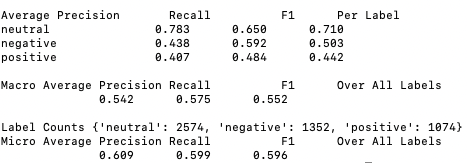


It seems like negation also gives us a boost in out micro averages! Next we move on to lexicons.

The function below was added to the python file and the code below it was added to processKaggle, and obtain the following results.

$$__def SL_features(document, word_features, SL):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    # count variables for the 4 classes of subjectivity
    weakPos = 0
    strongPos = 0
    weakNeg = 0
    strongNeg = 0
    for word in document_words:
        if word in SL:
            strength, posTag, isStemmed, polarity = SL[word]
            if strength == 'weaksubj' and polarity == 'positive':
                weakPos += 1
            if strength == 'strongsubj' and polarity == 'positive':
                strongPos += 1
            if strength == 'weaksubj' and polarity == 'negative':
                weakNeg += 1
            if strength == 'strongsubj' and polarity == 'negative':
                strongNeg += 1
            features['positivecount'] = weakPos + (2 * strongPos)
            features['negativecount'] = weakNeg + (2 * strongNeg)
    return features__$$

(positivelist, neutrallist, negativelist) = sentiment_read_subjectivity.read_subjectivity_three_types('/Users/princeabu/Desktop/GradSchool/Classes/IST664/FinalProj/FinalProjectData/kagglemoviereviews/SentimentLexicons/subjclueslen1-HLTEMNLP05.tff')

SL=sentiment_read_subjectivity.readSubjectivity('/Users/princeabu/Desktop/GradSchool/Classes/IST664/FinalProj/FinalProjectData/kagglemoviereviews/SentimentLexicons/subjclueslen1-HLTEMNLP05.tff')

featuresets = [(SL_features(d, word_features, SL), c) for (d, c) in docs]

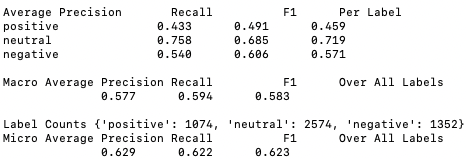

Lexicons greatly boosted our micro averages! This doesn't come as much of a surprise since Sentiment Lexicons allows us to leverage both subjectivity and polarity so including that as a feature proved especially helpful here.

Similarly, we can instead apply the linguistic inquiry and word count sentiment lexicon to see if that would be a better option. Using the same skeleton as the subjectivity function, we can construct a LIWC features function with the methods of the sentiment_read_LIWC_pos_neg_words program.

The function below was added to the python file and the code below it was added to processKaggle, and obtain the following results.

import sentiment_read_LIWC_pos_neg_words
(poslist, neglist) = sentiment_read_LIWC_pos_neg_words.read_words()

$$__def LIWC_features(document, word_features, poslist,neglist):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    # count variables for the 4 classes of subjectivity
    poswords = 0
    negwords = 0
    for word in document_words:
        if sentiment_read_LIWC_pos_neg_words.isPresent(word, poslist):
            poswords += 1
        if sentiment_read_LIWC_pos_neg_words.isPresent(word, neglist):
            negwords += 1
    features['positivecount'] = poswords
    features['negativecount'] = negwords
    return features__$$
    
featuresets = [(LIWC_features(d, word_features, poslist,neglist), c) for (d, c) in docs]

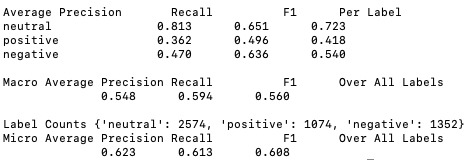

We see that this lexicon did not fair as well as the previous one.

If we put this all in a table to see their individual results, we can better understand which additions gave the most well-rounded improvements.

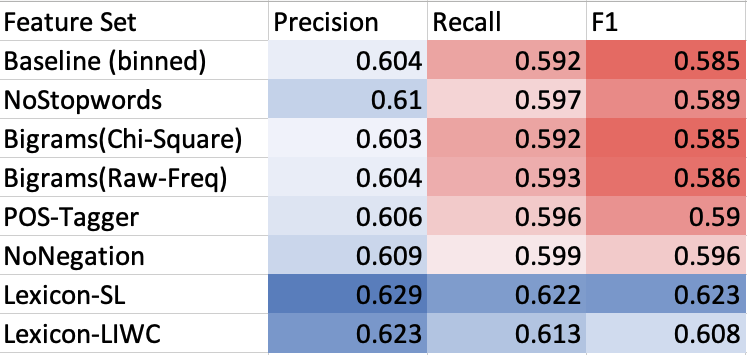

We can go through the exact same steps, and put the results in a table just like this but with the following changes:
- remove stop words with the appropriate filters 
- remove neutral reviews to create a more balanced training list
- use a different classification algorithm (Support Vector Machines)

Below are the tabulated results. 

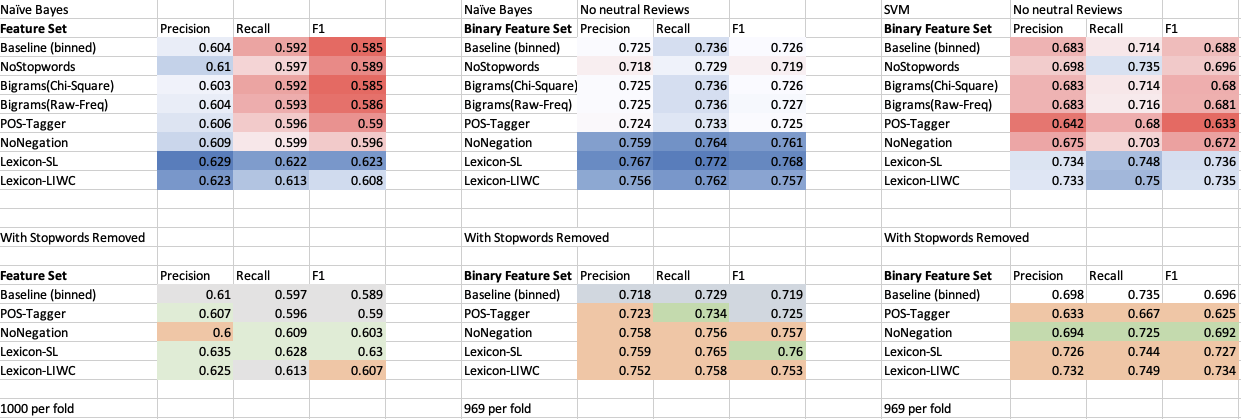

The first row of tables are color coated indicating highest and lowest scores within its resepctive column for that specific experiment. The second row of tables show how the affiliated scores change when we remove stop words. From here we see the best model in terms of F1 and precision was Naive Bayes classifiers with the subjectivity lexicon feature set. For SVC the same is true but with lower scores. The most striking thing we see is how much of a boost in overall accuracy we achieve with a more balanced data set. You can imagine kNearestNeighbors could potentially be a good mitigator with ambiguous nuetral reviews. 

# Summary

The Kaggle movie review data set is the perfect project to utilize many basic and advanced NLP techniques. These skills are important for any future data scientist in following a process to optimize your model for future deployment. Although the data set is initially biased, there are ways to partition it equally. The python files that we incorporated take on a brute force approach of processing and calculating the results, but they were essential to understand the underlying methods to obtaining them. Since we are not classifying cancer or heart disease, the F1 balanced score and precision are appropriate to focus on. We saw that when we removed neutral reviews, our classification algorithms were able to do significanly better at predicting sentiment. The highest overall accuracy achieved was about 77% when we removed neutral reviews, kept the stop words and applied the subjectivity lexicon with the Naive Bayes Classifier. The highest accuracy achieved by SVC was about 74%, also with the subjectivity lexicon, but took almost twice as long to run. However it is important to note that does not mean that these algorithms will perform this well on every movie data set. 
No doubt language is difficult to understand, especially from critics who love sarcasm. I learned much in regards to my individual research of what each of the statistic scores meant, and how to appropriately compare each model. In the future I hope to expand this project and do more advanced analysis with other classification algorithms and see if we can boost the accuracy even further. 

# Appendix
## Full updated code

In [ ]:
'''
  This program shell reads phrase data for the kaggle phrase sentiment classification problem.
  The input to the program is the path to the kaggle directory "corpus" and a limit number.
  The program reads all of the kaggle phrases, and then picks a random selection of the limit number.
  It creates a "phrasedocs" variable with a list of phrases consisting of a pair
    with the list of tokenized words from the phrase and the label number from 1 to 4
  It prints a few example phrases.
  In comments, it is shown how to get word lists from the two sentiment lexicons:
      subjectivity and LIWC, if you want to use them in your features
  Your task is to generate features sets and train and test a classifier.

  Usage:  python classifyKaggle.py  <corpus directory path> <limit number>

  This version uses cross-validation with the Naive Bayes classifier in NLTK.
  It computes the evaluation measures of precision, recall and F1 measure for each fold.
  It also averages across folds and across labels.
'''
# open python and nltk packages needed for processing
import os
import sys
import random
import nltk
from nltk.corpus import stopwords
import re
from nltk.collocations import *
from nltk.corpus import sentence_polarity
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC


## this code is commented off now, but can be used for sentiment lists
import sentiment_read_subjectivity


import sentiment_read_LIWC_pos_neg_words
# initialize positve and negative word prefix lists from LIWC 
#   note there is another function isPresent to test if a word's prefix is in the list
(poslist, neglist) = sentiment_read_LIWC_pos_neg_words.read_words()

                    # ***ADDED***
def LIWC_features(document, word_features, poslist,neglist):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    # count variables for the 4 classes of subjectivity
    poswords = 0
    negwords = 0
    for word in document_words:
        if sentiment_read_LIWC_pos_neg_words.isPresent(word, poslist):
            poswords += 1
        if sentiment_read_LIWC_pos_neg_words.isPresent(word, neglist):
            negwords += 1
    features['positivecount'] = poswords
    features['negativecount'] = negwords
    return features

## define a feature definition function here

# this function define features (keywords) of a document for a BOW/unigram baseline
# each feature is 'V_(keyword)' and is true or false depending
# on whether that keyword is in the document
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

#                       ***ADDED***
def bigram_document_features(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)
    return features
    
#                       ***ADDED***

def POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features

# ***ADDED***
negationwords = ['no', 'not', 'never', 'none', 'nowhere', 'nothing', 'noone', 'rather', 'hardly', 'scarcely', 'rarely', 'seldom', 'neither', 'nor']
def NOT_features(document, word_features, negationwords):
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = False
        features['V_NOT{}'.format(word)] = False
    # go through document words in order
    for i in range(0, len(document)):
        word = document[i]
        if ((i + 1) < len(document)) and ((word in negationwords) or (word.endswith("n't"))):
            i += 1
            features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
        else:
            features['V_{}'.format(word)] = (word in word_features)
    return features
    
# ***ADDED***
def SL_features(document, word_features, SL):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    # count variables for the 4 classes of subjectivity
    weakPos = 0
    strongPos = 0
    weakNeg = 0
    strongNeg = 0
    for word in document_words:
        if word in SL:
            strength, posTag, isStemmed, polarity = SL[word]
            if strength == 'weaksubj' and polarity == 'positive':
                weakPos += 1
            if strength == 'strongsubj' and polarity == 'positive':
                strongPos += 1
            if strength == 'weaksubj' and polarity == 'negative':
                weakNeg += 1
            if strength == 'strongsubj' and polarity == 'negative':
                strongNeg += 1
            features['positivecount'] = weakPos + (2 * strongPos)
            features['negativecount'] = weakNeg + (2 * strongNeg)
    return features
# initialize the positive, neutral and negative word lists
(positivelist, neutrallist, negativelist) = sentiment_read_subjectivity.read_subjectivity_three_types('/Users/princeabu/Desktop/GradSchool/Classes/IST664/FinalProj/FinalProjectData/kagglemoviereviews/SentimentLexicons/subjclueslen1-HLTEMNLP05.tff')
SL=sentiment_read_subjectivity.readSubjectivity('/Users/princeabu/Desktop/GradSchool/Classes/IST664/FinalProj/FinalProjectData/kagglemoviereviews/SentimentLexicons/subjclueslen1-HLTEMNLP05.tff')

## cross-validation ##
# this function takes the number of folds, the feature sets and the labels
# it iterates over the folds, using different sections for training and testing in turn
#   it prints the performance for each fold and the average performance at the end
def cross_validation_PRF(num_folds, featuresets, labels):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    # for the number of labels - start the totals lists with zeroes
    num_labels = len(labels)
    total_precision_list = [0] * num_labels
    total_recall_list = [0] * num_labels
    total_F1_list = [0] * num_labels
    
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        #classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        classifier = SklearnClassifier(SVC()).train(train_this_round)            # ***ADDED***
        
        
        # evaluate against test_this_round to produce the gold and predicted labels
        goldlist = []
        predictedlist = []
        for (features, label) in test_this_round:
            goldlist.append(label)
            predictedlist.append(classifier.classify(features))

        # computes evaluation measures for this fold and
        #   returns list of measures for each label
        print('Fold', i)
        (precision_list, recall_list, F1_list) \
                  = eval_measures(goldlist, predictedlist, labels)
        # take off triple string to print precision, recall and F1 for each fold
        '''
        print('\tPrecision\tRecall\t\tF1')
        # print measures for each label
        for i, lab in enumerate(labels):
            print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
              "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
        '''
        # for each label add to the sums in the total lists
        for i in range(num_labels):
            # for each label, add the 3 measures to the 3 lists of totals
            total_precision_list[i] += precision_list[i]
            total_recall_list[i] += recall_list[i]
            total_F1_list[i] += F1_list[i]

    # find precision, recall and F measure averaged over all rounds for all labels
    # compute averages from the totals lists
    precision_list = [tot/num_folds for tot in total_precision_list]
    recall_list = [tot/num_folds for tot in total_recall_list]
    F1_list = [tot/num_folds for tot in total_F1_list]
    # the evaluation measures in a table with one row per label
    print('\nAverage Precision\tRecall\t\tF1 \tPer Label')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
    
    # print macro average over all labels - treats each label equally
    print('\nMacro Average Precision\tRecall\t\tF1 \tOver All Labels')
    print('\t', "{:10.3f}".format(sum(precision_list)/num_labels), \
          "{:10.3f}".format(sum(recall_list)/num_labels), \
          "{:10.3f}".format(sum(F1_list)/num_labels))

    # for micro averaging, weight the scores for each label by the number of items
    #    this is better for labels with imbalance
    # first intialize a dictionary for label counts and then count them
    label_counts = {}
    for lab in labels:
      label_counts[lab] = 0 
    # count the labels
    for (doc, lab) in featuresets:
      label_counts[lab] += 1
    # make weights compared to the number of documents in featuresets
    num_docs = len(featuresets)
    label_weights = [(label_counts[lab] / num_docs) for lab in labels]
    print('\nLabel Counts', label_counts)
    #print('Label weights', label_weights)
    # print macro average over all labels
    print('Micro Average Precision\tRecall\t\tF1 \tOver All Labels')
    precision = sum([a * b for a,b in zip(precision_list, label_weights)])
    recall = sum([a * b for a,b in zip(recall_list, label_weights)])
    F1 = sum([a * b for a,b in zip(F1_list, label_weights)])
    print( '\t', "{:10.3f}".format(precision), \
      "{:10.3f}".format(recall), "{:10.3f}".format(F1))
    

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output: returns lists of precision, recall and F1 for each label
#      (for computing averages across folds and labels)
def eval_measures(gold, predicted, labels):
    
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []

    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        # for small numbers, guard against dividing by zero in computing measures
        if (TP == 0) or (FP == 0) or (FN == 0):
          recall_list.append (0)
          precision_list.append (0)
          F1_list.append(0)
        else:
          recall = TP / (TP + FP)
          precision = TP / (TP + FN)
          recall_list.append(recall)
          precision_list.append(precision)
          F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    return (precision_list, recall_list, F1_list)

## function to read kaggle training file, train and test a classifier 
def processkaggle(dirPath,limitStr):
  # convert the limit argument from a string to an int
  limit = int(limitStr)
  
  os.chdir(dirPath)
  
  f = open('./train.tsv', 'r')

  # loop over lines in the file and use the first limit of them
  phrasedata = []
  for line in f:
    # ignore the first line starting with Phrase and read all lines
    if (not line.startswith('Phrase')):
      # remove final end of line character
      line = line.strip()
      # each line has 4 items separated by tabs
      # ignore the phrase and sentence ids, and keep the phrase and sentiment
      phrasedata.append(line.split('\t')[2:4])
  
  # pick a random sample of length limit because of phrase overlapping sequences
  random.Random(664).shuffle(phrasedata) # set.seed to be able to compare models with same list of words ***ADDED***
  phraselist = phrasedata[:limit]
  
  print('Read', len(phrasedata), 'phrases, using', len(phraselist), 'random phrases')
  
  # create list of phrase documents as (list of words, label)
  phrasedocs = []
  # add all the phrases

  # each phrase has a list of tokens and the sentiment label (from 0 to 4)
  ### bin to only 3 categories for better performance
  for phrase in phraselist:
    tokens = nltk.word_tokenize(phrase[0])
        ## -----------Added to reduce complexity -------##   ***ADDED***
    rating = int(phrase[1])
    if(rating < 2):
       phrasedocs.append((tokens,'positive'))
    elif(rating > 2):
       phrasedocs.append((tokens,'negative'))
    #elif(rating == 2):
     #  phrasedocs.append((tokens,'neutral'))
  
  
    # phrasedocs.append((tokens, int(phrase[1])))
  # possibly filter tokens
  # lowercase - each phrase is a pair consisting of a token list and a label
  docs = []
  for phrase in phrasedocs:
    lowerphrase = ([w.lower() for w in phrase[0]], phrase[1])
    docs.append (lowerphrase)
  # print a few
  for phrase in docs[:10]:
    print (phrase)


  nltkstopwords = nltk.corpus.stopwords.words('english') # ***ADDED***
  # continue as usual to get all words and create word features
  #all_words_list = [word for (sent,cat) in docs for word in sent]
    
    ## BIGRAM FEATURE EXTRACTOR ***ADDED***
  #finder = BigramCollocationFinder.from_words(all_words_list) # ***ADDED***
  #bigram_measures = nltk.collocations.BigramAssocMeasures()   # ***ADDED***
  #bigram_features = finder.nbest(bigram_measures.chi_sq, 500) # ***ADDED***
 
  
  all_words_list = [word for (sent,cat) in docs for word in sent if word not in nltkstopwords] #***ADDED***
  all_words = nltk.FreqDist(all_words_list)
  print(len(all_words))

  # get the 1500 most frequently appearing keywords in the corpus
  word_items = all_words.most_common(1500)
  word_features = [word for (word,count) in word_items]

  # feature sets from a feature definition function
  featuresets = [(document_features(d, word_features), c) for (d, c) in docs]
  #featuresets = [(bigram_document_features(d, word_features, bigram_features), c) for (d, c) in docs]  # ***ADDED***
  #featuresets = [(POS_features(d, word_features), c) for (d, c) in docs]                               # ***ADDED***
  #featuresets = [(SL_features(d, word_features, SL), c) for (d, c) in docs]                            # ***ADDED***
  #featuresets = [(NOT_features(d, word_features, negationwords), c) for (d, c) in docs]                # ***ADDED***
  #featuresets = [(LIWC_features(d, word_features, poslist,neglist), c) for (d, c) in docs]             # ***ADDED***
  # train classifier and show performance in cross-validation
  # make a list of labels
  label_list = [c for (d,c) in docs]
  labels = list(set(label_list))    # gets only unique labels
  num_folds = 5
  cross_validation_PRF(num_folds, featuresets, labels)


"""
commandline interface takes a directory name with kaggle subdirectory for train.tsv
   and a limit to the number of kaggle phrases to use
It then processes the files and trains a kaggle movie review sentiment classifier.

"""
if __name__ == '__main__':
    if (len(sys.argv) != 3):
        print ('usage: classifyKaggle.py <corpus-dir> <limit>')
        sys.exit(0)
    processkaggle(sys.argv[1], sys.argv[2])
